In [ ]:
import pandas as pd
import numpy as np

# Assuming the dataset is in CSV format
df = pd.read_csv("/content/mcdonalds.csv")  # Replace with actual file path


# Convert Yes/No to binary
MD_x = df.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0)

# Check column-wise means
print(MD_x.mean().round(2))

Like                  0.6
Eat                   0.6
QuickService          0.8
Cheap                 0.6
Tasty                 0.6
Clean                 0.6
FriendlyStaff         0.4
KidsLikeIt            0.8
HealthyOptions        0.4
ConvenientLocation    0.8
FamilyFriendly        1.0
dtype: float64


/tmp/ipython-input-20-2218484855.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  MD_x = df.iloc[:, 0:11].applymap(lambda x: 1 if x == "Yes" else 0)


[0.56 0.2  0.17 0.07 0.  ]


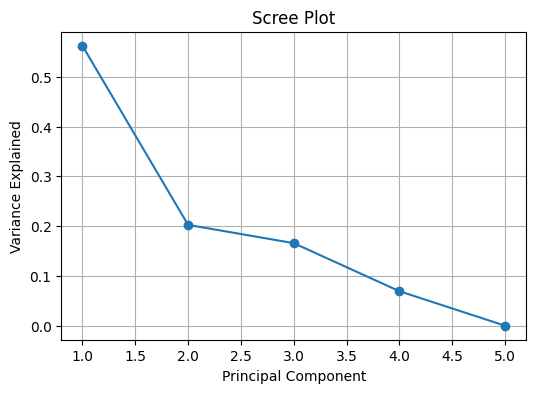

In [ ]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

pca = PCA()
components = pca.fit_transform(MD_x)

# Explained variance
print(np.round(pca.explained_variance_ratio_, 2))

# Scree plot
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(pca.explained_variance_ratio_)+1), pca.explained_variance_ratio_, marker='o')
plt.title('Scree Plot')
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.grid(True)
plt.show()

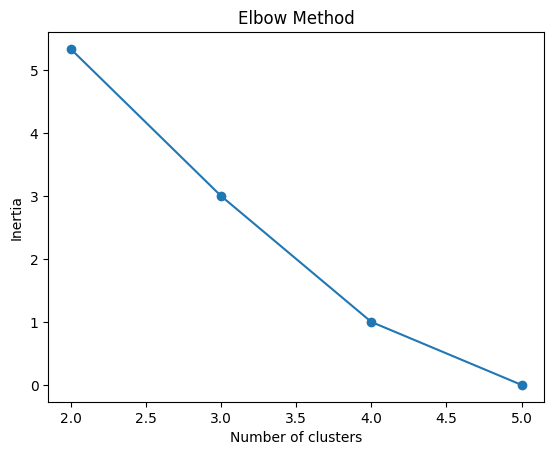

In [ ]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# Elbow method to determine optimal k
inertia = []  # Clear the old values

for k in range(2, 6):  # Only test clusters 2 through 5 (max 5 samples)
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(MD_x)
    inertia.append(kmeans.inertia_)

# Now plotting will work
plt.plot(range(2, 6), inertia, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Inertia")
plt.title("Elbow Method")
plt.show()



In [ ]:
kmeans_final = KMeans(n_clusters=4, random_state=42, n_init=10)
df["cluster"] = kmeans_final.fit_predict(MD_x)


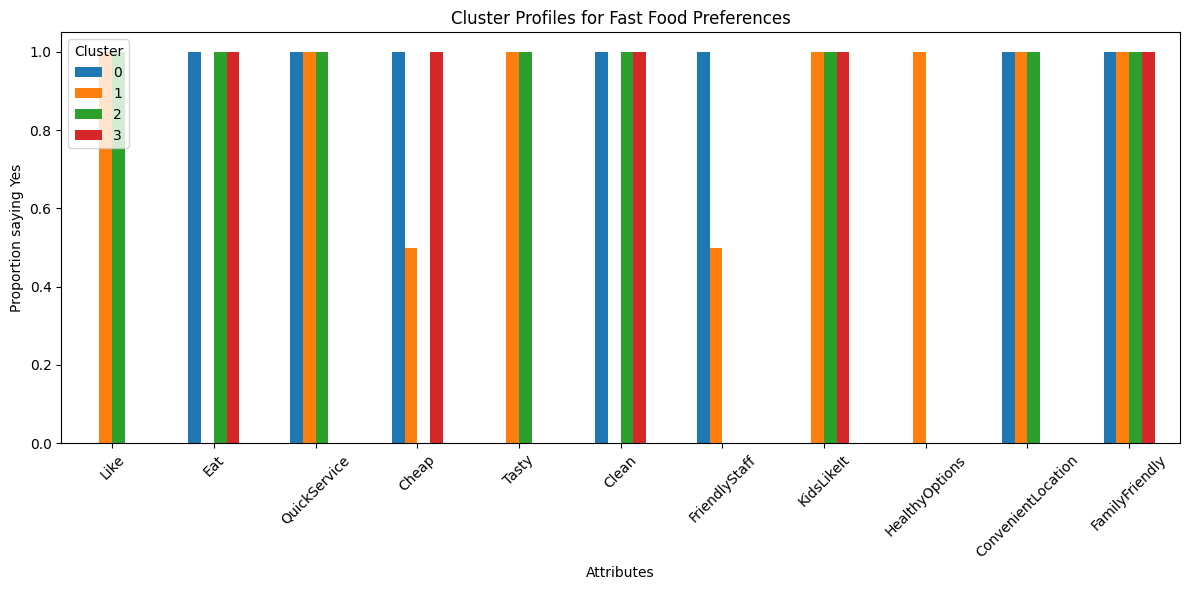

In [ ]:
import seaborn as sns

# Barplot for segment profile
segment_profile = MD_x.copy()
segment_profile["cluster"] = df["cluster"]
cluster_means = segment_profile.groupby("cluster").mean().T

cluster_means.plot(kind="bar", figsize=(12, 6))
plt.title("Cluster Profiles for Fast Food Preferences")
plt.ylabel("Proportion saying Yes")
plt.xlabel("Attributes")
plt.xticks(rotation=45)
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()


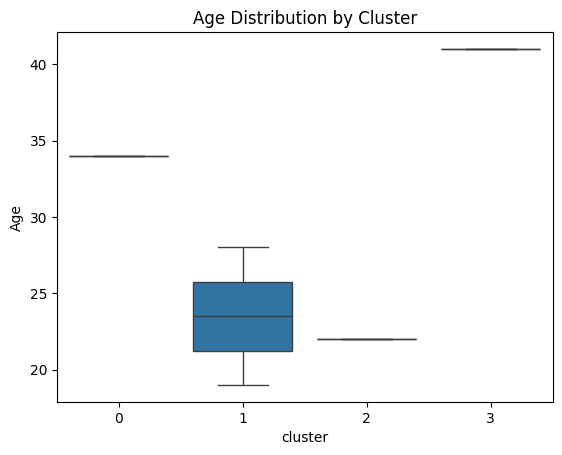

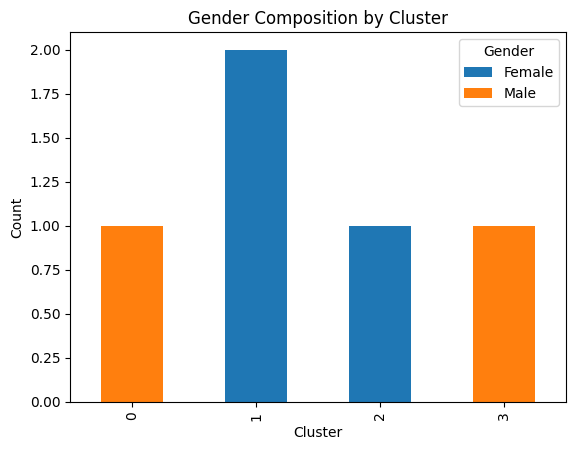

In [ ]:
# Example: Age vs Cluster
sns.boxplot(x="cluster", y="Age", data=df)
plt.title("Age Distribution by Cluster")
plt.show()

# Example: Gender vs Cluster
pd.crosstab(df["cluster"], df["Gender"]).plot(kind="bar", stacked=True)
plt.title("Gender Composition by Cluster")
plt.xlabel("Cluster")
plt.ylabel("Count")
plt.show()


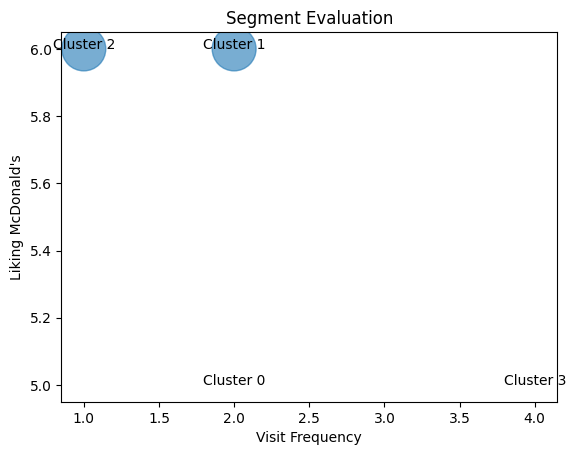

In [ ]:
# Convert 'VisitFrequency' and 'Like' to numeric
df["VisitFrequency_n"] = pd.factorize(df["VisitFrequency"])[0] + 1
df["Like_n"] = 6 - pd.factorize(df["Like"])[0]  # reverse coding

# Compute averages
visit = df.groupby("cluster")["VisitFrequency_n"].mean()
like = df.groupby("cluster")["Like_n"].mean()
female = df.groupby("cluster")["Gender"].apply(lambda x: (x == "Female").mean())

# Plot evaluation
plt.scatter(visit, like, s=female * 1000, alpha=0.6)
for i in range(len(visit)):
    plt.text(visit.iloc[i], like.iloc[i], f"Cluster {i}", ha='center')
plt.xlabel("Visit Frequency")
plt.ylabel("Liking McDonald's")
plt.title("Segment Evaluation")
plt.show()


In [ ]:
import statsmodels.api as sm

for c in sorted(df["cluster"].unique()):
    subset = df[df["cluster"] == c]
    if len(subset) < 2:
        print(f"Skipping Cluster {c} — Not enough samples (n={len(subset)})")
        continue

    X = MD_x.loc[subset.index]
    y = subset["Like_n"]
    X = sm.add_constant(X)
    model = sm.OLS(y, X).fit()
    print(f"\nCluster {c} Regression Summary:")
    print(model.summary())



Skipping Cluster 0 — Not enough samples (n=1)

Cluster 1 Regression Summary:
                            OLS Regression Results                            
Dep. Variable:                 Like_n   R-squared:                        -inf
Model:                            OLS   Adj. R-squared:                   -inf
Method:                 Least Squares   F-statistic:                       nan
Date:                Wed, 09 Jul 2025   Prob (F-statistic):                nan
Time:                        14:49:36   Log-Likelihood:                 65.784
No. Observations:                   2   AIC:                            -127.6
Df Residuals:                       0   BIC:                            -130.2
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------

/usr/local/lib/python3.11/dist-packages/statsmodels/stats/stattools.py:74: ValueWarning: omni_normtest is not valid with less than 8 observations; 2 samples were given.
  warn("omni_normtest is not valid with less than 8 observations; %i "
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: divide by zero encountered in scalar divide
  return 1 - self.ssr/self.centered_tss
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1795: RuntimeWarning: divide by zero encountered in divide
  return 1 - (np.divide(self.nobs - self.k_constant, self.df_resid)
/usr/local/lib/python3.11/dist-packages/statsmodels/regression/linear_model.py:1717: RuntimeWarning: divide by zero encountered in scalar divide
  return np.dot(wresid, wresid) / self.df_resid
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:1527: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale
